# VAE paper-to-code ワークフロー (PyTorch公式実装版)

このノートブックは、PyTorch公式の VAE MNIST サンプルをベースに、環境構築から実行・可視化までを一気通貫で追体験できるよう再構成しています。上から順に実行すると、公式コードをそのまま動かしつつ、周辺の補助セルで結果を確認しやすくなります。

## チェックリスト概要
- [ ] 1. 環境準備：Python + PyTorch + データセット
- [ ] 2. PyTorch公式VAEサンプルのコードをざっと確認する
- [ ] 3. 公式スクリプトを好みのハイパーパラメータで実行する
- [ ] 4. 出力された再構成画像・生成サンプルを可視化する
- [ ] 5. 必要に応じて追加実験（エポック数やバッチサイズ変更など）を試す
- [ ] 6. 結果を整理して次のアクションに繋げる

## 1. 環境準備
GPU (RTX3070/4070 など) を持つ環境で PyTorch が CUDA や Accelerator API を正しく認識しているかを確認します。ノートブックの実行前に `python -m venv` や conda などで仮想環境を作成しておくと管理が楽です。

In [51]:
from pathlib import Path
import os
import sys

def _locate_project_root(start: Path) -> Path:
    current = start.resolve()
    while current.parent != current:
        if all((current / marker).exists() for marker in ["src", "pyproject.toml"]):
            return current
        current = current.parent
    raise FileNotFoundError("プロジェクトルートを特定できませんでした。")

PROJECT_ROOT = _locate_project_root(Path.cwd())
DATA_DIR = PROJECT_ROOT / "data"
EXAMPLES_DIR = PROJECT_ROOT / "examples"
RESULTS_DIR = EXAMPLES_DIR / "vae" / "results"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Exists src?: {(PROJECT_ROOT / 'src').exists()}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"RESULTS_DIR: {RESULTS_DIR}")

PROJECT_ROOT: /home/user/vae-paper-to-code
Exists src?: True
DATA_DIR: /home/user/vae-paper-to-code/data
RESULTS_DIR: /home/user/vae-paper-to-code/examples/vae/results


In [52]:
import platform
import torch

print(f"Python  : {platform.python_version()}")
print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
print(f"Accelerator available: {torch.accelerator.is_available()}")
if torch.cuda.is_available():
    for idx in range(torch.cuda.device_count()):
        print(f"  - GPU{idx}: {torch.cuda.get_device_name(idx)}")
else:
    print("GPUが利用できません。CPUまたは他のアクセラレータで実行します。")

Python  : 3.11.13
PyTorch : 2.8.0+cu128
CUDA    : True
Accelerator available: True
  - GPU0: NVIDIA GeForce RTX 3070


### 追加ライブラリのインストール (必要に応じて)
依存関係が未インストールの場合は、以下のセルで `pip` を実行します。既に整っていればスキップしてください。

In [53]:
import sys
import subprocess

# 実行例: requirements.txt を一括インストール
# subprocess.run([sys.executable, "-m", "pip", "install", "-r", str(PROJECT_ROOT / "requirements.txt")], check=True)

print("必要に応じて上のコメントを外して実行してください。")

必要に応じて上のコメントを外して実行してください。


## 2. データセットを準備
公式スクリプトは `examples/data/` 以下に MNIST をダウンロードします。このセルでは torchvision を使って一度データを取得し、フォルダ構造と画像の中身を押さえておきます（後続セルで公式コードから同じ場所を再利用します）。

In [54]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root=str(DATA_DIR), train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root=str(DATA_DIR), train=False, download=True, transform=transform)
input_shape = train_ds[0][0].shape

print(f"train size: {len(train_ds)}, test size: {len(test_ds)}, input shape: {input_shape}")

train size: 60000, test size: 10000, input shape: torch.Size([1, 28, 28])


/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/micromamba/envs/vae/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIF

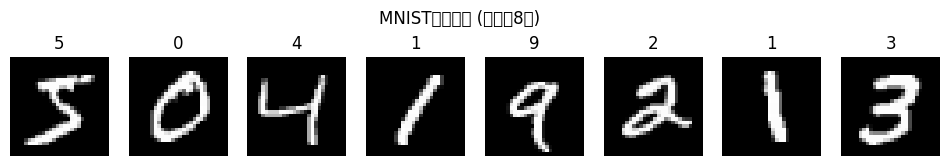

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for ax, (img, label) in zip(axes, [train_ds[i] for i in range(8)]):
    img_to_plot = img.squeeze().numpy()
    ax.imshow(img_to_plot, cmap="gray")
    ax.axis("off")
    ax.set_title(str(label))
plt.suptitle("MNISTサンプル (最初の8枚)")
plt.show()

## 3. PyTorch公式VAEスクリプトを確認
今回の主役は PyTorch リポジトリ付属の `examples/vae/main.py` です。ここではファイルの場所を確認し、ざっと構造を俯瞰しておきます。

In [56]:
from itertools import islice
from src.pytorch_examples import vae as official_vae

script_path = official_vae._example_script_path()
print(f"Official script path: {script_path}")

with open(script_path, "r", encoding="utf-8") as f:
    preview = list(islice(f, 40))
print("".join(preview))

Official script path: /home/user/vae-paper-to-code/examples/vae/main.py
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-accel', action='store_true', 
                    help='disables accelerator')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches 

## 4. 実行設定を整える
公式スクリプトはコマンドライン引数でエポック数やバッチサイズを指定します。ここでは辞書形式で設定を管理し、後続セルで CLI 引数に変換して実行します。

In [57]:
VAE_RUN_CONFIG = {
    "epochs": 5,
    "batch_size": 128,
    "log_interval": 100,
    "seed": 1,
    "use_accelerator": True,
}
VAE_RUN_CONFIG

{'epochs': 5,
 'batch_size': 128,
 'log_interval': 100,
 'seed': 1,
 'use_accelerator': True}

In [58]:
import time
from pathlib import Path

def _build_cli_args(config: dict) -> list[str]:
    args: list[str] = []
    if config.get("batch_size") is not None:
        args.extend(["--batch-size", str(config["batch_size"])])
    if config.get("epochs") is not None:
        args.extend(["--epochs", str(config["epochs"])])
    if config.get("seed") is not None:
        args.extend(["--seed", str(config["seed"])])
    if config.get("log_interval") is not None:
        args.extend(["--log-interval", str(config["log_interval"])])
    if not config.get("use_accelerator", True):
        args.append("--no-accel")
    return args

def run_official_training(config: dict) -> dict:
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    before = {p.name: p.stat().st_mtime for p in RESULTS_DIR.glob("*.png")}

    cli_args = _build_cli_args(config)
    print("実行コマンド:")
    print("python examples/vae/main.py " + " ".join(cli_args))
    start = time.time()
    official_vae.run_vae_example(cli_args, data_root=DATA_DIR)
    elapsed = time.time() - start

    generated = []
    for p in RESULTS_DIR.glob("*.png"):
        mtime = p.stat().st_mtime
        if p.name not in before or mtime > before[p.name]:
            generated.append((mtime, p))
    generated.sort(key=lambda x: x[0])

    return {
        "cli_args": cli_args,
        "results_dir": str(RESULTS_DIR.resolve()),
        "generated_images": [str(p) for _, p in generated],
        "elapsed_sec": elapsed,
    }

### スクリプトを実行する
設定を確認したら下のセルを実行して PyTorch 公式 VAE を走らせます。初回はデータのダウンロードと結果画像の保存に数分かかる場合があります。

In [59]:
latest_run = run_official_training(VAE_RUN_CONFIG)
latest_run

実行コマンド:
python examples/vae/main.py --batch-size 128 --epochs 5 --seed 1 --log-interval 100
Using device: cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 550.513916
Train Epoch: 1 [0/60000 (0%)]	Loss: 550.513916
Train Epoch: 1 [12800/60000 (21%)]	Loss: 179.929642
Train Epoch: 1 [12800/60000 (21%)]	Loss: 179.929642
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.957687
Train Epoch: 1 [25600/60000 (43%)]	Loss: 155.957687
Train Epoch: 1 [38400/60000 (64%)]	Loss: 139.382645
Train Epoch: 1 [38400/60000 (64%)]	Loss: 139.382645
Train Epoch: 1 [51200/60000 (85%)]	Loss: 131.098373
Train Epoch: 1 [51200/60000 (85%)]	Loss: 131.098373
====> Epoch: 1 Average loss: 164.4236
====> Epoch: 1 Average loss: 164.4236
====> Test set loss: 127.1185
====> Test set loss: 127.1185
Train Epoch: 2 [0/60000 (0%)]	Loss: 123.358589
Train Epoch: 2 [0/60000 (0%)]	Loss: 123.358589
Train Epoch: 2 [12800/60000 (21%)]	Loss: 124.826736
Train Epoch: 2 [12800/60000 (21%)]	Loss: 124.826736
Train Epoch: 2 [25600/60000 (43%)]	Loss: 120.

{'cli_args': ['--batch-size',
  '128',
  '--epochs',
  '5',
  '--seed',
  '1',
  '--log-interval',
  '100'],
 'results_dir': '/home/user/vae-paper-to-code/examples/vae/results',
 'generated_images': ['/home/user/vae-paper-to-code/examples/vae/results/reconstruction_1.png',
  '/home/user/vae-paper-to-code/examples/vae/results/sample_1.png',
  '/home/user/vae-paper-to-code/examples/vae/results/reconstruction_2.png',
  '/home/user/vae-paper-to-code/examples/vae/results/sample_2.png',
  '/home/user/vae-paper-to-code/examples/vae/results/reconstruction_3.png',
  '/home/user/vae-paper-to-code/examples/vae/results/sample_3.png',
  '/home/user/vae-paper-to-code/examples/vae/results/reconstruction_4.png',
  '/home/user/vae-paper-to-code/examples/vae/results/sample_4.png',
  '/home/user/vae-paper-to-code/examples/vae/results/reconstruction_5.png',
  '/home/user/vae-paper-to-code/examples/vae/results/sample_5.png'],
 'elapsed_sec': 18.028974771499634}

## 5. 結果の可視化
公式スクリプトは `examples/vae/results/` 以下に再構成画像と生成サンプルをエポックごとに保存します。ここでは最新ファイルを一覧し、中身を表示します。

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

result_files = sorted(RESULTS_DIR.glob("*.png"))
print(f"Results dir: {RESULTS_DIR}")
print(f"Total images: {len(result_files)}")
if result_files:
    display(pd.DataFrame({
        "filename": [p.name for p in result_files],
        "modified": [pd.to_datetime(p.stat().st_mtime, unit="s") for p in result_files],
    }))
else:
    print("画像がまだ生成されていません。上のセルを実行してから再確認してください。")

Results dir: /home/user/vae-paper-to-code/examples/vae/results
Total images: 10


,filename,modified
0,reconstruction_1.png,2025-09-28 10:08:17.126044750
1,reconstruction_2.png,2025-09-28 10:08:20.917878151
2,reconstruction_3.png,2025-09-28 10:08:23.531853914
3,reconstruction_4.png,2025-09-28 10:08:27.230846167
4,reconstruction_5.png,2025-09-28 10:08:31.023609877
5,sample_1.png,2025-09-28 10:08:17.645926237
6,sample_2.png,2025-09-28 10:08:21.425381422
7,sample_3.png,2025-09-28 10:08:24.039357185
8,sample_4.png,2025-09-28 10:08:27.737922192
9,sample_5.png,2025-09-28 10:08:31.534808635


In [61]:
def group_latest_images(files):
    buckets: dict[str, Path] = {}
    for path in files:
        stem = path.stem
        if "_" in stem:
            prefix, suffix = stem.split("_", 1)
        else:
            prefix, suffix = stem, ""
        if prefix not in buckets or path.stat().st_mtime > buckets[prefix].stat().st_mtime:
            buckets[prefix] = path
    return buckets

latest_images = group_latest_images(result_files)
latest_images

{'reconstruction': PosixPath('/home/user/vae-paper-to-code/examples/vae/results/reconstruction_5.png'),
 'sample': PosixPath('/home/user/vae-paper-to-code/examples/vae/results/sample_5.png')}

reconstruction: reconstruction_5.png


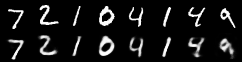

sample: sample_5.png


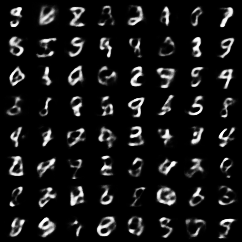

In [62]:
from IPython.display import display
from PIL import Image

def show_image(path: Path, title: str):
    print(f"{title}: {path.name}")
    display(Image.open(path))

for key in sorted(latest_images):
    show_image(latest_images[key], key)

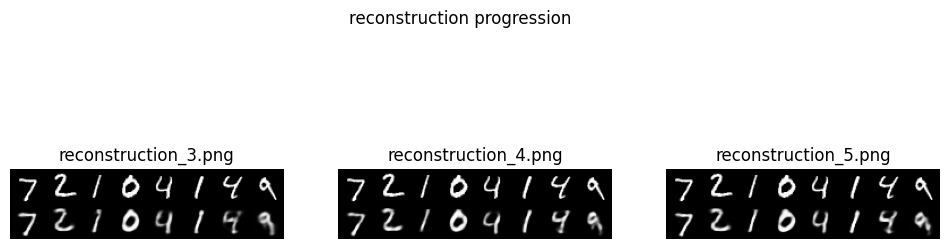

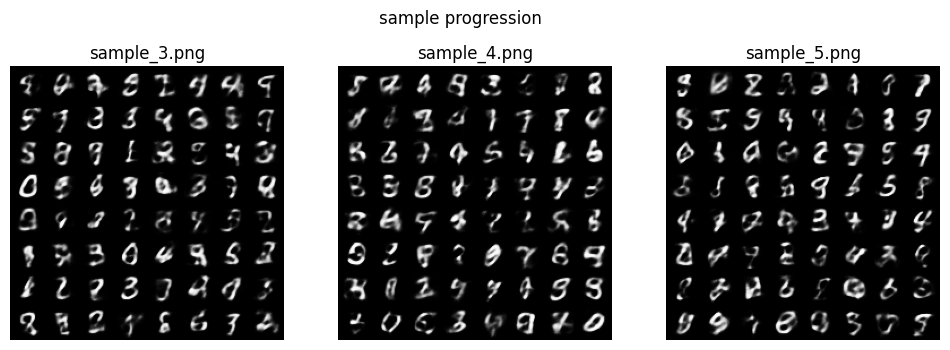

In [63]:
def show_progression(prefix: str, count: int = 3):
    files = sorted(RESULTS_DIR.glob(f"{prefix}_*.png"))
    if not files:
        print(f"{prefix}: 画像が見つかりません。")
        return
    subset = files[-count:] if len(files) >= count else files
    fig, axes = plt.subplots(1, len(subset), figsize=(4 * len(subset), 4))
    if len(subset) == 1:
        axes = [axes]
    for ax, path in zip(axes, subset):
        img = Image.open(path)
        ax.imshow(img, cmap="gray")
        ax.set_title(path.name)
        ax.axis("off")
    fig.suptitle(f"{prefix} progression")
    plt.show()

show_progression("reconstruction")
show_progression("sample")

### 追加の調査
公式スクリプトは学習曲線をファイルに出力しませんが、生成された画像からエポックごとの改善を追うことができます。より詳細な記録が必要になったら、ログ保存用の変更を公式コードに少し加えることも検討してください。

In [64]:
import numpy as np

def summarize_image_stats(images: dict[str, Path]) -> pd.DataFrame:
    rows = []
    for key, path in images.items():
        img = Image.open(path)
        arr = np.array(img.convert("L")) / 255.0
        rows.append({
            "type": key,
            "shape": arr.shape,
            "mean_pixel": arr.mean(),
            "std_pixel": arr.std(),
        })
    return pd.DataFrame(rows)

summarize_image_stats(latest_images)

,type,shape,mean_pixel,std_pixel
0,reconstruction,"(62, 242)",0.091146,0.250837
1,sample,"(242, 242)",0.091328,0.221607


## 6. 実験のバリエーション
エポック数やバッチサイズ、アクセラレータ有無などを切り替えて挙動を比較できます。下のヘルパーは複数設定で公式スクリプトを順に実行し、生成された画像パスを記録します（時間がかかるので必要なときだけコメントを外してください）。

In [65]:
def sweep_runs(base_config: dict, variants: list[dict]) -> list[dict]:
    logs = []
    for variant in variants:
        cfg = base_config.copy()
        cfg.update(variant)
        print("\n--- running variant ---")
        print(variant)
        summary = run_official_training(cfg)
        logs.append({
            "variant": variant,
            "summary": summary,
        })
    return logs

# 実行例 (時間に注意):
# sweep_logs = sweep_runs(
#     VAE_RUN_CONFIG,
#     [
#         {"epochs": 3, "seed": 0},
#         {"epochs": 3, "use_accelerator": False},
#     ],
# )
# sweep_logs

## 7. 次のステップ
- 公式スクリプトに軽微な変更を加えて学習曲線（CSV）を保存する
- 生成画像を GIF 化する、または WandB / TensorBoard に記録する
- 論文や他実装との違いをドキュメント化し、再現性メモを残す

このノートブックをベースにすれば、PyTorch 公式実装の挙動を素早く確認しながら自分用の改善ポイントを洗い出せます。必要に応じてセルを複製し、追加の記録メモを挿入してください。